In [2]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster, DirectTimeSeriesRegressionForecaster, DirectTabularRegressionForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
from sktime.forecasting.compose import make_reduction
from sklearn.exceptions import ConvergenceWarning
import requests
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.compose import YfromX
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.compose import ColumnwiseTransformer
from sktime.forecasting.compose import ForecastingPipeline

import warnings
warnings.filterwarnings('ignore')

Getting predictions from internal model

In [3]:
price_old_df = pd.read_csv('https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/supply_load_price.csv', parse_dates=['Date (MST)'], index_col='Date (MST)')
price_old_df = price_old_df.asfreq('H')
price_old_df = price_old_df.sort_values(by='Date (MST)')
price_old_df = price_old_df['2022-12':]
price_df = price_old_df['price']
y = price_df
selected_cols = ['ail']
X = price_old_df[selected_cols]

In [4]:
test_size = 48
forcast_len = 12

y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=test_size+forcast_len)

fh = ForecastingHorizon(np.arange(1, forcast_len+1))

In [5]:
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
# import my_pipelinee

direct_pipe_t = TransformedTargetForecaster(
        steps=[
            ("targetlogtransformer", LogTransformer()),
            (
                "targetforecaster",
                make_reduction(
                    RandomForestRegressor(n_estimators=1, n_jobs=-1),
                    window_length=3,
                    strategy="direct",
                ),
            ),
        ]
    )


In [6]:
direct_pipe_t.fit(y=y_train, X=X_train, fh=fh)

TransformedTargetForecaster(steps=[('targetlogtransformer', LogTransformer()),
                                   ('targetforecaster',
                                    DirectTabularRegressionForecaster(estimator=RandomForestRegressor(n_estimators=1, n_jobs=-1),
                                                                      window_length=3))])

In [7]:
direct_pipe_t.cutoff

DatetimeIndex(['2023-03-29 10:00:00'], dtype='datetime64[ns]', name='Date (MST)', freq='H')

In [8]:
log_transformed_y = direct_pipe_t.transform(y_train, X_train)  # does all the log trasnformations on y
log_transformed_y.mean()

4.787093381755568

In [9]:
y_target, X_reduced = direct_pipe_t.forecaster_._transform(log_transformed_y, X_train)  # TransfomedTargetForecaster does not transform X, only y.
# y_target[2828].tolist()

In [10]:
direct_pipe_t.forecaster_._get_last_window()

(array([3.90540113, 3.87473642, 3.91022138]),
 array([[10292],
        [10280],
        [10201]], dtype=int64))

In [11]:
# get the last window in the loop to make predictions for the next 12 hours 
last_window = direct_pipe_t.forecaster_._get_last_window()

# Flatten each array and convert them to lists
flatten_arrays = [array.flatten().tolist() for array in last_window]

# Concatenate the flattened arrays
result_list = sum(flatten_arrays, [])
result_list

[3.905401129119259,
 3.8747364206421295,
 3.9102213834815176,
 10292,
 10280,
 10201]

In [12]:
# create feature names for the last window lagged features which is the transformed features 

features = ['pr', 'ail']
new_list = []

for feature in features:
    for i in range(3, 0, -1):
        new_list.append(f'{feature}_lag{i}')
X_test_reduced_df = pd.DataFrame(
    [result_list],
    columns=new_list
).round(3)

X_test_reduced_df

,pr_lag3,pr_lag2,pr_lag1,ail_lag3,ail_lag2,ail_lag1
0,3.905,3.875,3.91,10292,10280,10201


In [13]:
#get all the 12 models
direct_pipe_t.get_fitted_params()["forecaster"].get_fitted_params()["estimators"]

[RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1),
 RandomForestRegressor(n_estimators=1, n_jobs=-1)]

In [19]:
shap_bar_values

.values =
array([-0.03090077,  0.10072348, -0.93273147, -0.02138469, -0.00735932,
        0.00728901])

.base_values =
array([[4.80969778],
       [4.80969778],
       [4.80969778],
       [4.80969778],
       [4.80969778],
       [4.80969778]])

.data =
pr_lag3         3.905
pr_lag2         3.875
pr_lag1         3.910
ail_lag3    10292.000
ail_lag2    10280.000
ail_lag1    10201.000
Name: 0, dtype: float64

In [25]:
shap_bar_values.base_values = shap_bar_values.base_values[0]
shap_bar_values

.values =
array([-0.03090077,  0.10072348, -0.93273147, -0.02138469, -0.00735932,
        0.00728901])

.base_values =
array([4.80969778])

.data =
pr_lag3         3.905
pr_lag2         3.875
pr_lag1         3.910
ail_lag3    10292.000
ail_lag2    10280.000
ail_lag1    10201.000
Name: 0, dtype: float64

In [24]:
shap_values

array([-0.03090077,  0.10072348, -0.93273147, -0.02138469, -0.00735932,
        0.00728901])

In [55]:
X_test_reduced_df

,pr_lag3,pr_lag2,pr_lag1,ail_lag3,ail_lag2,ail_lag1
0,3.905,3.875,3.91,10292,10280,10201


In [56]:
X_test_reduced_df.iloc[0]

pr_lag3         3.905
pr_lag2         3.875
pr_lag1         3.910
ail_lag3    10292.000
ail_lag2    10280.000
ail_lag1    10201.000
Name: 0, dtype: float64

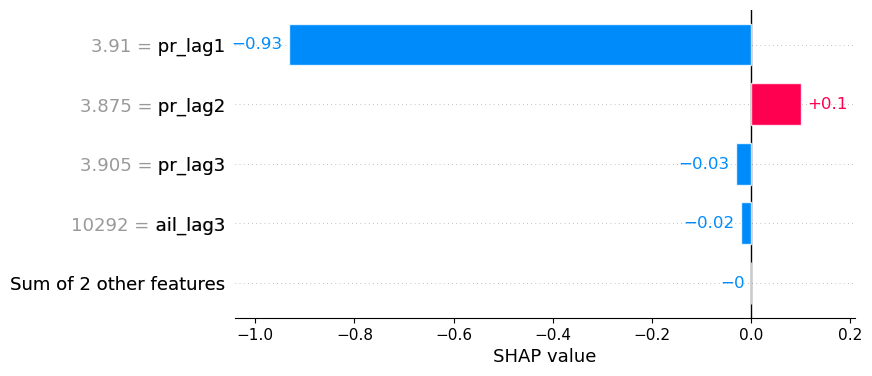

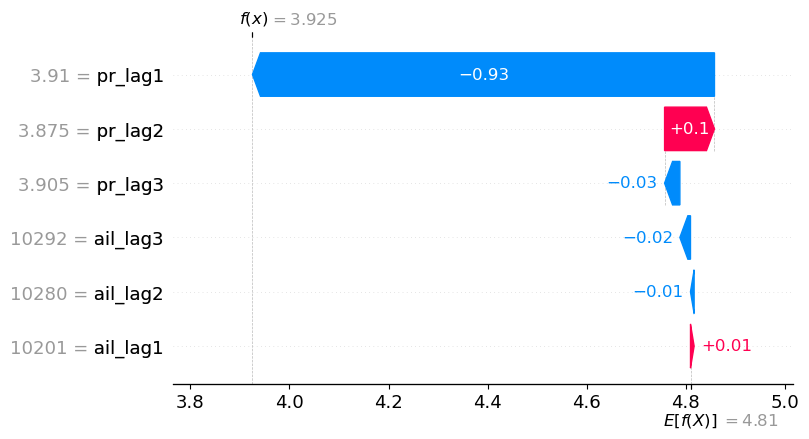

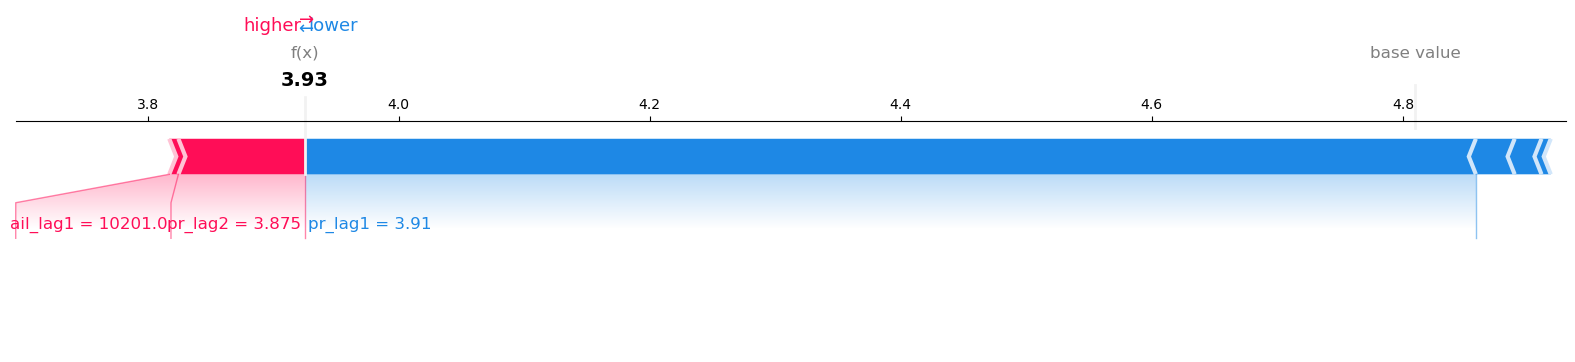

In [45]:
import shap
shap.initjs()

# main proof of concept

models = direct_pipe_t.get_fitted_params()["forecaster"].get_fitted_params()["estimators"]
for model in models[0]:    
    
    explainerModel = shap.TreeExplainer(model)

    shap_bar_values = explainerModel(X_test_reduced_df.iloc[0])
    shap.plots.bar(shap_bar_values, max_display=5) 
       
    shap_bar_values.base_values = shap_bar_values.base_values[0][0]
    shap.plots.waterfall(shap_bar_values)
    
    # shap values for force plot 
    shap_values= explainerModel.shap_values(X_test_reduced_df.iloc[0])
    shap_values

    shap.force_plot(
    explainerModel.expected_value[0],
    shap_values,
    X_test_reduced_df.iloc[[0]],
    matplotlib=True)



In [33]:
shap_bar_values.base_values = shap_bar_values.base_values[0]

In [58]:
X_test_reduced_df.iloc[0]

pr_lag3         3.905
pr_lag2         3.875
pr_lag1         3.910
ail_lag3    10292.000
ail_lag2    10280.000
ail_lag1    10201.000
Name: 0, dtype: float64

In [59]:
type(X_test_reduced_df.iloc[0])

pandas.core.series.Series

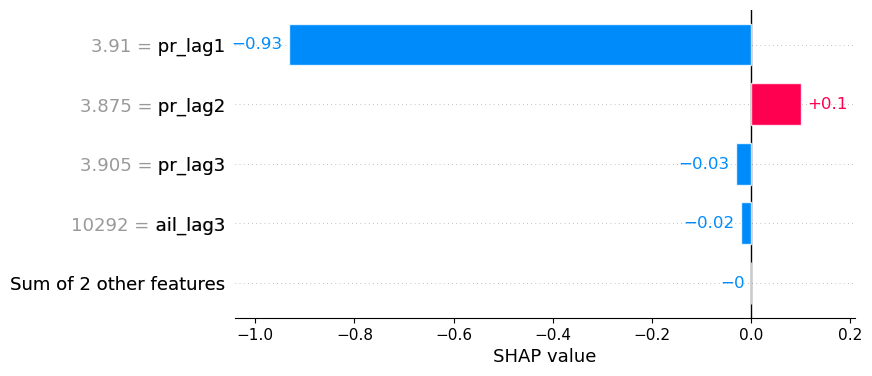

In [42]:
explainerModel = shap.TreeExplainer(models[0])

shap_bar_values = explainerModel(X_test_reduced_df.iloc[0])
shap.plots.bar(shap_bar_values, max_display=5) 
    
# shap_bar_values.base_values = shap_bar_values.base_values[0]
# shap.plots.waterfall(shap_bar_values)

In [48]:
# check the mean value of predictions and the expected value

model.predict(X_reduced).mean()

4.794792440064061

In [49]:
explainerModel.expected_value[0].round(3)

4.81

In [50]:
shap_df = pd.DataFrame(
    [shap_values],
    columns=new_list
).round(2)

shap_df

,pr_lag3,pr_lag2,pr_lag1,ail_lag3,ail_lag2,ail_lag1
0,-0.03,0.1,-0.93,-0.02,-0.01,0.01


In [51]:
import pandas as pd

# Assuming your DataFrame is named "df"
df_transposed = shap_df.transpose()

# Add a new column to store the absolute values
df_transposed['abs_values'] = df_transposed[0].abs()
df_transposed

# Sort the transposed DataFrame based on absolute values in descending order
df_transposed_sorted = df_transposed.sort_values(by='abs_values', ascending=False)


# Remove a column
df_transposed_sorted = df_transposed_sorted.drop("abs_values", axis=1)

# Rename a column
df_transposed_sorted = df_transposed_sorted.rename(columns={0: "shap_val"})
df_transposed_sorted

# # Select the first four columns and rename them
top_four_cols = df_transposed_sorted.iloc[:4]
# top_four_cols.columns = ['First', 'Second', 'Third', 'Fourth']

# # Sum the remaining columns together and create a new column named "others"
other_cols_sum = df_transposed_sorted.iloc[4:]['shap_val'].sum().round(4)
other_cols_sum

other_cols_sum_row = pd.DataFrame([other_cols_sum], columns=['shap_val'], index=['Others'])
other_cols_sum_row

# # Concatenate the top four columns and the "others" column
shap_df = pd.concat([top_four_cols, other_cols_sum_row], axis=0)

shap_df


,shap_val
pr_lag1,-0.93
pr_lag2,0.10
pr_lag3,-0.03
ail_lag3,-0.02
Others,0.00


In [52]:

explainerModel.expected_value[0]

4.809697775830237

In [53]:

base_value = explainerModel.expected_value[0]

# Calculate new feat value which is the base value + shap value and percent of increase or decrease with respect to the base value 

shap_df['new_feat_value'] = base_value + shap_df['shap_val']
shap_df['percent'] = shap_df.apply(lambda row: (base_value - row['new_feat_value']) / base_value * -100 if row['shap_val'] < 0 else (row['new_feat_value'] - base_value) / base_value * 100, axis=1)
shap_df

,shap_val,new_feat_value,percent
pr_lag1,-0.93,3.879698,-19.335934
pr_lag2,0.10,4.909698,2.079133
pr_lag3,-0.03,4.779698,-0.623740
ail_lag3,-0.02,4.789698,-0.415827
Others,0.00,4.809698,0.000000


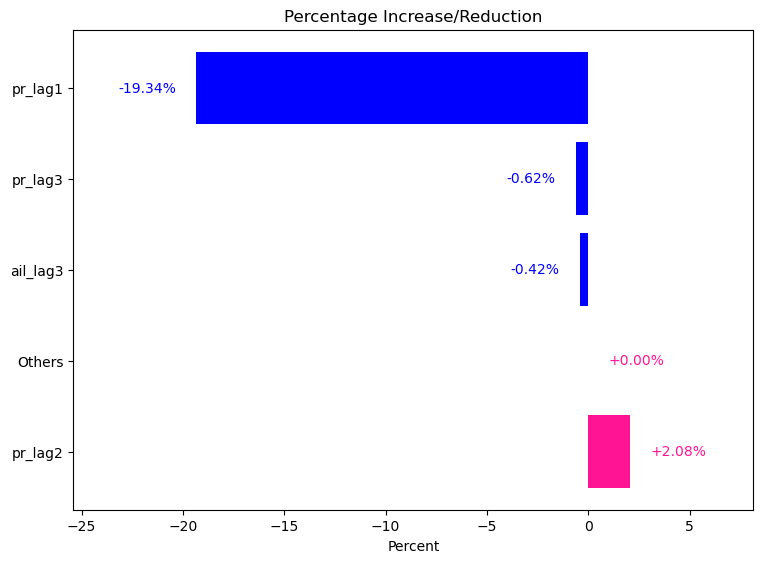

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
df = shap_df.reset_index()


# Sort the dataframe by the percentage values in descending order
df = df.sort_values('percent', ascending=False)

# Set the y-axis as the feature names (indices)
y = df['index']


# Set the x-axis as the percentage values
x = df['percent']

# Determine the colors for the bars based on the positive/negative values
colors = ['deeppink' if val > 0 else 'blue' for val in x]

# Plot the horizontal bars
bars = ax.barh(y, x, color=colors)

# Add labels outside the bars with proper spacing
for i, bar in enumerate(bars):
    value = df['percent'].iloc[i]
    if value >= 0:
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2,
                f'+{value:.2f}%', ha='left', va='center', color='deeppink', fontsize=10)
    else:
        ax.text(bar.get_width() - 1, bar.get_y() + bar.get_height() / 2,
                f'{value:.2f}%', ha='right', va='center', color='blue', fontsize=10)

# Set the x-axis label
ax.set_xlabel('Percent')

# Set the title of the plot
ax.set_title('Percentage Increase/Reduction')

# Adjust x-axis limits to include extra space
xmin, xmax = ax.get_xlim()
ax.set_xlim(xmin - 5, xmax + 5)  # Add 5 to both sides of the x-axis limits

# Adjust spacing for better visualization
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

# Show the plot
plt.show()


In [ ]:
transformed_y_vals = direct_pipe_t._get_inverse_transform(direct_pipe_t.transformers_pre_, shap_values).tolist()
transformed_y_vals

[1.1261729044973026,
 0.9157697270423772,
 0.39034886171999333,
 0.9954268430680182,
 1.0216687937106683,
 1.0335350750286112]